# Tutorial - Hydrogen production and storage
Suppose that we would like to produce hydrogen from wind energy by using an alkaline electrolysis system, as described below:

        Wind turbine -- (power) --> Alkaline electrolysis --> (h2)

The rating of our wind turbine and electrolysis unit are equal and fixed to 10 MW and we would like to know **what is the annual hydrogen production (AHP)**?.

### Introduction

A naive answer would be to multiply the electrolysis rating (10 MW) by its efficiency at full load (67%) and the total number of hours (8760 h/year):

In [94]:
AHP_naive = 10*0.67*8760

println("Annual hydrogen production is: $AHP_naive MWh")

Annual hydrogen production is: 58692.0 MWh


However, since we depend on a fluctuating wind power, the average power rating available for hydrogen production is lower than the design rating (10 MW).

A better approximation would be to use the average rating of a historic data for wind power:

In [95]:
using CSV           # Package
using DataFrames    # Package

df = CSV.read("hourWind.csv",DataFrame)     # reading historical data of wind turbine loads
design_rating = 10                          # MW - Wind turbine rating assumed
windPower = round.(df.load*design_rating,digits=3)  # sizing and rouding data

avg_windPower = sum(windPower)/length(windPower)

println("Average wind power generation is $avg_windPower MW")

Average wind power generation is 6.25522397260274 MW


In [96]:
AHP_average = avg_windPower*0.67*8760

println("Annual hydrogen production is: $AHP_average MWh")

Annual hydrogen production is: 36713.16054 MWh


This is a better approach, which we can improve by adding two additional caracteristics of alkaline electrolysis:
* An efficiency curve : in practice, AEC have variable efficiency that depends on the power rating (or equipment load) that the equipment is subjected to. 
* A minimal power rating: additionally, there is also a minimal threshold of power rating that the electrolysis unit needs to operate safely.

Here we going to use vivi to write a optimization problem that includes this caracteristics and can be later extended to examinate problems including hydrogen storage.

### Minimal load

First let's import the functions from **vivi**:

In [168]:
include("../../src/vivi.jl") # the file location may be different in your pc

vivi

#### Alkaline electrolysis - Tech

Now, we need to create a representation of the alkaline electrolysis unit. 

                power --> aec --> h2

First, we should define the inputs and outputs of the AEC system as **Resources**:

        Resource(type,amount,unit,[[value_t]])

* type: a string identifying the resource (e.g., water)
* amount: a value or array of the rate of that type (e.g., 100, 10)
* unit: the unit of the amount (e.g., kg, W, etc.)
* value_t: is the specific value of the resource on time t (e.g., 10 EUR/kg)

In [137]:
power = ResourceType(n="power",u="MW",c=[0;;])
hydrogen = ResourceType(n="H2",u="MW",c=[1;;])

# Defining power input of electrolysis
aec_in = Resource(t=power,r=[10])

# Defining hydrogen output of electrolysis
aec_out = Resource(t=hydrogen,r=[10*0.66865])

Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0 0; 1 1])

Finally, we create a Tech:

        Tech(type,[in],[out],[[size,cost]])

* type: the name of the technology
* in: the resources inputs
* out: the resources outputs
* size,cost: datapoints of size and cost for the technology

In [138]:
# Creating a basic Tech with the information available
alk = Tech(n="AWE",i=[aec_in],o=[aec_out])

Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[10], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0 0; 1 1])], Heat[], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (0, 1000.0), (0, 1), (-1, 1), true, 1, Real[1])

and include additional constraints about their size and partial load limits:

        Tech.limits = [min,max]
        Tech.loads = [min,max,turnOff]

* min: minimal size/load
* max: maximal size/load
* turnOff: a binary variable to define if the Tech can be shut down (turnOff=true) or not (turnOff=false)

So, since we defined the resources input as for a system of 10 MW, the sizes of the electrolysis Tech (f) should be limited to 1:

$$ 1 \leq f \leq 1$$

In [139]:
# Adding size limits
alk.s = (1,1)

(1, 1)

We also would like to limite the minimal load to 15% of the power rating and enable the possibility of shutting down the electrolysis:

$$ 0.15 \leq f_t \leq 1 $$

$$ turnOff = true $$

In [140]:
# Adding load limits and shutdown possibility
alk.l = (0.15,1)
alk.off = true

true

We can visualize the balance of resource by using the "vivi_sankey" function

In [141]:
vivi_sankey(alk)

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

#### Problem boundaries - inputs / outputs

Our problem boundaries start with the wind power, since we are not modifying the turbine size, and ends with the hydrogen production from the electrolyzer. Since the electrolyzer may not be able to use all the wind power (due to the minimal load restriction), we also need to include a curtailment possibility to conservate the energy.

        (power) ----> aec --> (h2)
                |
                --> (power)[cut]

We define resources as previously, but including an array of amounts and values to capture the effect of variability of wind power. Since the wind power is produced locally, we can define its value as zero to simplify the objective function of the optimization:

In [142]:
hours = length(windPower)

windIn = Resource(t = power, r=windPower)

Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])

**OBS**: It is important to use the same type name in "power" for the boundaries and Techs. Otherwise the optimization will think that the resources are different.

The same can be done for the hydrogen and curtailment (which is a type of "power"). The main difference is that we are going to set the value of H2 as "1" and curtailment as "0". This means that the curtailment does not add up to the net energy products, while the hydrogen does (by a factor of 1).

Also notice that the amount set for H2 and curtailment are **Inf**, which tells the optimization that these values are free variables to be optimized.

In [143]:
# Hydrogen
h2 = Resource(t = hydrogen , r = [Inf for i=1:hours])

# Curtailment
powerLost = ResourceType(n="power",u="MW",c=[0;;])
cut = Resource(t=powerLost,r=[Inf for i=1:hours])

Resource(ResourceType("power", Real[0;;], "MW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1])

#### Problem struct and solving

Now we just need to input these informations as a problem to be solved by **vivi**

        Problem(inputs,processes,outputs,utilities,storage)

* inputs: the resources that are allowed/required to by imported by the system.
* processes: the Techs that are included in the problem
* outputs: the resources that are allowed/required to by exported by the system.
* utilities: also Techs that are included in the problem, but only auxiliates the processes by delivering important resources (i.e., heat, steam, cooling)
* storage: the Storage possibilities included in the problem.

In [144]:
problem = Problem(i = [windIn], p = [alk], o =[h2,cut])

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[10], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0 0; 1 1])], Heat[], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (1, 1), (0.15, 1), (-1, 1), true, 1, Real[1])], Tech[], Storage[])

Our problem is rather simple, is just a Tech that connects to different types of resources, as shown in the graph below:

In [145]:
vivi_graph(problem)

data: [
  "scatter with fields line, mode, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y"
]

layout: "layout with fields hovermode, margin, showarrow, showlegend, template, titlefont, xaxis, and yaxis"

We can create and solve a optimization problem by calling the **vivi** function with the specified problem. In this case the objective function is rather simple:

$$ max \; obj = \sum_t r_{o,t}v_{o,t} - \sum_t r_{i,t}v_{i,t} = \sum_t E_{h2,t} $$

* $\sum_t r_{o,t}v_{o,t}$ = resources out times their value
* $\sum_t r_{i,t}v_{i,t}$ = minus the sum of resources in times their value.

Because we specified the value of the wind power and curtailment as zero, the objective function becomes the maximization of annual hydrogen production (in energy basis).

**OBS**: Gurobi can be much faster for these time series problem, so we can specify the use of Gurobi solver in the vivi function to save time.

In [123]:
using Gurobi
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105122 rows, 70081 columns and 219002 nonzeros
Model fingerprint: 0x8b192cfd
Variable types: 61321 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 105122 rows and 70081 columns
Presolve time: 0.08s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.13 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 36015.2 36015.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.601522949595e+04, best bound 3.601522949595e+04, gap 0.0000%

User-callback calls 250, time in user-callback 0.00 sec
* Solver : Gu

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.7184305, 1.3707325, 1.4275677499999997, 2.6271258499999997, 4.23857235, 3.9691064, 3.3499364999999997, 5.4080411999999995, 5.29503935, 5.795858199999999], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[10], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0 0; 1 1])], Heat[], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (1, 1), (0.15, 1), (-1, 1), true, 1.0, Real[0.0, 0.0, 

As it can be seen from the optimal objective value, the maximum annual hydrogen production in this case is $3.60152\cdot 10^4$ MWh. A bit below what we previously estimated, because now we included the minimal load restriction.

### Including partial load

We can add the effects of partial load into the Resources:

        Resource.loadEffect = [
            [load, percentage of amount]
        ]

* load = the percentual load of the Tech
* percentage of amount = the percentage of the Resource amount produced in that load

In [146]:
alk.i[1].pw = [
    0.15 0.15011
    0.51 0.50907
    1.0 1.0
    ]

alk.o[1].pw = [
    0.15 0.15/0.66865*0.76086
    0.51 0.51/0.66865*0.71408
    1.0 1.0
    ]

3×2 Matrix{Float64}:
 0.15  0.170686
 0.51  0.544651
 1.0   1.0

Now solving again the problem give us a different result:

In [125]:
problem = Problem(i = [windIn], p = [alk], o =[h2,cut])
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 157682 rows, 96361 columns and 411722 nonzeros
Model fingerprint: 0x54a4d38e
Variable types: 78841 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 157676 rows and 96357 columns
Presolve time: 2.20s
Presolved: 6 rows, 4 columns, 14 nonzeros
Found heuristic solution: objective 36664.980861
Variable types: 2 continuous, 2 integer (2 binary)

Root relaxation: objective 3.666970e+04, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.8858865261310453, 1.5236541436928908, 1.58286520620682, 2.832566925618454, 4.415989456337972, 4.166053441834885, 3.5855923206485416, 5.500699355508932, 5.395887478459251, 5.860408756034465], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[10], Real[0.15 0.15011; 0.51 0.50907; 1.0 1.0])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0.15 0.17068571001271218; 0.51 0.5446508636805505

As it can be seen, the annual hydrogen production is $ 3.66697 \cdot 10^4 $ MWh, roughtly 2% higher than the previous case. This difference can be attributed to the partial load efficiency.

### Including storage and a constant offtaker

One important thing about our results so far it that they assume that there will be always an offtaker to use the hydrogen at whatever rate of production. In practice the offtaker may be a chemical plant that can only run constantly, therefore the output of hydrogen has to be fix and to do so we need storage to have a buffer.

        (power) ----> aec --> (h2) --> store --> offtaker --> (h2_plant)
                |
                --> (power)[cut]

To include this in our problem, let's first create a storage representation:

        Storage(type,initial charge)

* type: the Resource type that the storage is connected to
* intial charge: the percentage of the total capacity that the storage will start and end the optimization.

**OBS**: Here is important to fix the starting load as 100%, because otherwise the system may not have the initial energy required to provide hydrogen in the first couple of hours of simulation.

In [147]:
storeInit= 1 # 100% starting load and finishing load

h2Store = Storage(n="H2 tank", t=hydrogen, a=storeInit)

Storage("H2 tank", ResourceType("H2", Real[1;;], "MW"), 1, Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (0, 1000.0), (-1, 1), 1, Real[1])

By default, the storage can be infinity, so let's put some constraints in the size of storage:

In [148]:
storeMax = 60 # MWh of max storage
h2Store.s = (0,storeMax)

(0, 60)

Now we need to make sure that the offtaker operates at a constant rate. This can be done by creating another tech with a fixed load that converts hydrogen into another type of hydrogen, the one that will be used at the plant. This way the optimization will still be allowed to size the offtaker, but it will need to keep the rating constant during the time series. 

In [158]:
offtaker_in = [Resource(t=hydrogen,r=[10])]

hydrogen_plant = ResourceType(n="H2_plant",u="MW",c=[1;;])
offtaker_out = [Resource(t=hydrogen_plant,r=[10])]

offtaker = Tech(n="offtaker",i =offtaker_in,o=offtaker_out)
offtaker.l=(1,1)
offtaker.off =false # 100-100% load and can't be shut down.

false

Since now our system outputs "h2_plant", we need to update type of the h2 resource that we assumed as our problem boundary:

In [159]:
h2.t = hydrogen_plant

ResourceType("H2_plant", Real[1;;], "MW")

Now if we rerun the optimization including the offtaker as a process...

In [169]:
problem = Problem(i=[windIn],p=[alk,offtaker],o=[h2,cut],st=[h2Store])
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280327 rows, 148923 columns and 639488 nonzeros
Model fingerprint: 0x9df5ad3c
Variable types: 122643 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 227753 rows and 115745 columns
Presolve time: 0.87s
Presolved: 52574 rows, 33178 columns, 150085 nonzeros
Variable types: 20407 continuous, 12771 integer (12771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.457770e+03, 9727 iterations, 0.40 seconds (0.3

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[1;;], "MW"), Real[1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677  …  1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 0.0, 5.01, 8.088, 0.0, 1.7763568394002505e-15], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real

We see that the optimization chooses the maximum size of storage (60 MWh) and the output of H2 is much lower than in the previous cases $0.945777 \cdot 10^4$ MWh. Meaning that it is much harder to deliver a constant output of hydrogen than a variable one.

This solution also shows us that the offtaker rating roughly 11% of the reference value given (10MW), about 1.1 MW for a hydrogen system of 10 MW. This means that the hydrogen production would need to be almost 10x larger than the actual use rating! Certainly this would not be viable.

### Flexibilizing the offtaker

We can improve this previous result by making the offtaker more flexible. For instance, we could design a chemical plant that could also operate with 15-100% hydrogen input by changing the operating conditions accordingly. Assuming that this is possible, let's examine the impacts on the hydrogen production side.

For this, we just need to modify the constraint of the offtaker loads to a range (15-100%)

In [170]:
offtaker.l=(0.15,1) # 100-100% load and can't be shut down.
offtaker.off = false

false

Now, if we optimize again the same problem...

In [171]:
problem = Problem(i=[windIn],p=[alk,offtaker],o=[h2,cut],st=[h2Store])
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280327 rows, 148923 columns and 639488 nonzeros
Model fingerprint: 0x8399fc4c
Variable types: 122643 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 210386 rows and 107058 columns
Presolve time: 1.32s
Presolved: 69941 rows, 41865 columns, 186361 nonzeros
Variable types: 29094 continuous, 12771 integer (12771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   22143    4.5555322e+03   0.000000e+00   1

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[1;;], "MW"), Real[1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 6.6861456065019444, 1.0029218409752916, 6.6861456065019444, 6.6861456065019444, 1.0029218409752916, 1.0029218409752916  …  1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916, 1.0029218409752916], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7763568394002505e-15], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "M

Now the number of hydrogen production is much more promissing, because we can reach a number very close to the theoretical maximum (3.66697e4 MWh). It is also interesting that we don't need the maximum amount of hydrogen storage, but the specific number of 55.4 MWh.

However, we may still have a technical challenge related to the ramping limits. To understand that, let's observe results for the first hours of operation:

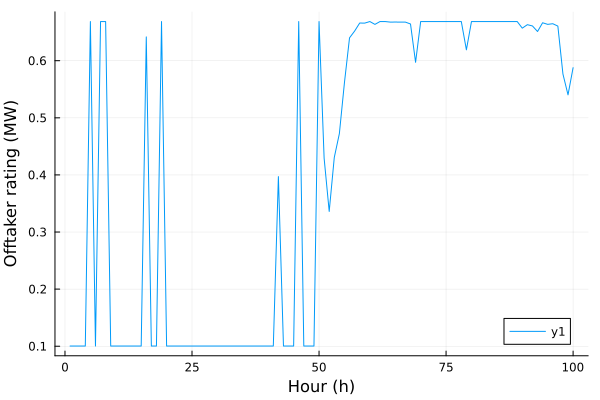

In [172]:
plot(answer.p[2].f_t[1:100])
xaxis!("Hour (h)")
yaxis!("Offtaker rating (MW)")

As you can observe, the optimal solution seems to rely on some abrupt changes in the offtaker rating. Some chemical processes may not be able to adjust so quickly to this changes in hydrogen input. Similarly, the hydrogen storage may not be able to charge or discharge at unlimited ratings. Therefore we should examinate if the answer would change significantly with ramping limits. 

### Ramping limits

In [174]:
offtaker.rp = (-0.2,0.2)
h2Store.rp = (-0.2,0.2)

(-0.2, 0.2)

In [175]:
problem = Problem(i=[windIn],p=[alk,offtaker],o=[h2,cut],st=[h2Store])
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 315363 rows, 148923 columns and 744596 nonzeros
Model fingerprint: 0x831fe687
Variable types: 122643 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 211641 rows and 106907 columns
Presolve time: 1.48s
Presolved: 103722 rows, 42016 columns, 285849 nonzeros
Variable types: 29245 continuous, 12771 integer (12771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolved: 103722 rows, 42016 columns, 285849 nonzeros

Concurrent spin time: 0.06s

Solv

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[1;;], "MW"), Real[1.079654100849677, 1.0796541008496767, 2.5191929019825796, 1.0796541008496767, 1.0796541008496767, 1.0796541008496767, 1.0796541008496767, 1.0796541008496767, 1.0796541008496767, 1.0796541008496767  …  3.3112178026765164, 1.8716790015436138, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.079654100849677, 1.0796541008496767, 2.5191929019825796, 2.5191929019825796, 1.0796541008496767], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7763568394002505e-15], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), 

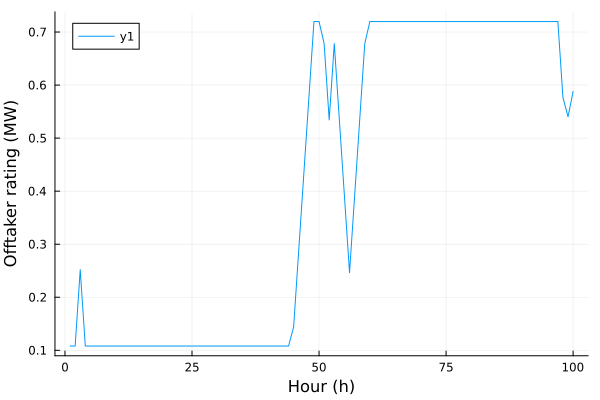

In [176]:
plot(answer.p[2].f_t[1:100])
xaxis!("Hour (h)")
yaxis!("Offtaker rating (MW)")

Now the solution does not have so intense spikes that would make it difficult to operate, but we see that it is necessary to increase the hydrogen storage to the maximum to keep on with the overall hydrogen production.

### Adding a compressor consumption

In general, hydrogen is stored in the compressed form, which consumes electricity. Therefore, we were being a bit optimistic in the previous analysis. We can try to include the extra consumptions of power by adding Techs that represent the compressor and modifying the hydrogen resources type to differentiate the hydrogen produced from the hydrogen compressed. For instance, assuming a specific consumution of 4 kWh/kg H2, our compressor can be written as:



        (power) ----> aec --(h2)--> compressor --(h2_200bar)--> store --(h2_200bar)--> offtaker --(h2_plant)-->
                |
                --(power)-->[cut]

In [181]:
spec_cons = 4/33.3 # kWh_power/kg_h2 / (kWh_h2/kg_h2)

comp_in = [Resource(t=hydrogen,r=[10]),
           Resource(t=power,r=[spec_cons*10])]

h2_comp = ResourceType(n="h2_200bar",u="MW",c=[1;;]) 
comp_out = [Resource(t=h2_comp,r=[10])]

h2Comp = Tech(n="compressor",i=comp_in,o=comp_out)

Tech("compressor", Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[10], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[1.2012012012012012], Real[0 0; 1 1])], Resource[Resource(ResourceType("h2_200bar", Real[1;;], "MW"), Real[10], Real[0 0; 1 1])], Heat[], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (0, 1000.0), (0, 1), (-1, 1), true, 1, Real[1])

Now, we just need to change the type of hydrogen being stored and taken from the offtaker:

In [182]:
h2Store.t = h2_comp
offtaker.i[1].t = h2_comp

ResourceType("h2_200bar", Real[1;;], "MW")

The new problem looks like this:

In [183]:
problem = Problem(i=[windIn],p=[alk,offtaker,h2Comp],o=[h2,cut],st=[h2Store])
vivi_graph(problem)

data: [
  "scatter with fields line, mode, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y"
]

layout: "layout with fields hovermode, margin, showarrow, showlegend, template, titlefont, xaxis, and yaxis"

In [185]:
answer = vivi(problem,Gurobi.Optimizer) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402965 rows, 192724 columns and 911038 nonzeros
Model fingerprint: 0xc1d51845
Variable types: 157684 continuous, 35040 integer (35040 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 261442 rows and 128567 columns
Presolve time: 3.90s
Presolved: 141523 rows, 64157 columns, 378224 nonzeros
Variable types: 42919 continuous, 21238 integer (21238 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolve removed 11805 rows and 6679 columns
Root relaxation presolved: 129718 rows, 5747

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[1;;], "MW"), Real[0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552, 0.9706843982248552  …  1.6333483444624017, 1.169612810106905, 2.463858674406707, 3.7581045387065135, 3.566905089622441, 2.2726592253226343, 3.5669050896224412, 4.861150953922255, 5.8850597782174034, 4.5908139139176], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 3.552713678800501e-15, 3.552713678800501e-15, 0.0, 0.0, 8.881784197001252e-16, 0.0], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(Resourc

Now we see again a reduction in the total hydrogen production due to the consumption of power in the compression.

## Including costs

Finally, we should also take into consideration the costs of storage in the optimization. For this, let's assume that a cost of 0.105 MEUR/MWh of storage:

        Tech.cost = [
            [
                [size_1,cost_1], [size_2,cost_2] ...
            ]
        ]

It is important to say that the cost in this case has to be per time step, meaning we have to provide the average cost per hour EUR/MWh-h. We can do that by calculating the average capital recovery factor.

In [188]:
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 

h2Store.c = [
[
    0 0
    60 60*0.105E6*CRF
]
]

1-element Vector{Matrix{Float64}}:
 [0.0 0.0; 60.0 73.24987620843021]

In addition, we need to specify a value for the hydrogen for every time step:

        Resource.value = [cost_t1, cost_t2, ...]

In [191]:
lhv_h2 = 33.3/1000
c_h2 = 3/lhv_h2 # USD/kg / (MWh/kg)

h2.t.c = fill(c_h2,hours,1)

8760×1 Matrix{Float64}:
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
  ⋮
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901
 90.0900900900901

In [192]:
problem = Problem(i=[windIn],p=[alk,offtaker,h2Comp],o=[h2,cut],st=[h2Store])


Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[90.0900900900901; 90.0900900900901; … ; 90.0900900900901; 90.0900900900901;;], "MW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1])], Tech[Tech("AWE", Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[10], Real[0.15 0.15011; 0.51 0.50907; 1.0 1.0])], Resource[Resource(ResourceType("H2", Real[1;;], "MW"), Real[6.6865], Real[0.15 0.17068571001271218; 0.51 0.5446508636805505; 1.0 1.0])], Heat[], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (1, 1), (0.15, 1), (-1,

Finally, we need to activate CAPEX calculation in the objective function when calling the vivi function:

$$ max \; obj = \sum_t r_{o,t}v_{o,t} - \sum_t r_{i,t}v_{i,t} - \sum_t CAPEX_t = \sum_t E_{h2,t}*c_{h2,t} - \sum_t CAPEX_{store,t} $$

In [193]:
answer = vivi(problem,Gurobi.Optimizer,capex=true) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402981 rows, 192732 columns and 911062 nonzeros
Model fingerprint: 0xe9610a8e
Variable types: 157688 continuous, 35044 integer (35044 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [9e+01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 261458 rows and 128575 columns
Presolve time: 3.81s
Presolved: 141523 rows, 64157 columns, 378224 nonzeros
Variable types: 42919 continuous, 21238 integer (21238 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolve removed 11805 rows and 6679 columns
Root relaxation presolved: 129718 rows, 5747

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[90.0900900900901; 90.0900900900901; … ; 90.0900900900901; 90.0900900900901;;], "MW"), Real[0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854  …  2.8998966998999602, 1.7783560211482463, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854, 0.8411555090637854], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 3.552713678800501e-15, 3.552713678800501e-15, 0.0, 0.0, 8.8817841

It is interesting to see that in this case we don't maximize the storage anymore. Also, it is important to highlight that the objective value is no longer annual hydrogen production, but "profits of H2 - CAPEX of storage" in EUR for a year. We can calculate the annual hydrogen production by summing the hydrogen output:

In [195]:
AHP = sum(answer.o[1].r)

println("In this case the AHP was: $AHP MWh")

In this case the AHP was: 33874.17409950425 MWh


Of course, this result is dependent on the assumptions of cost and value we did previously. For instance, if we assume now a value of 5 EUR/kg of hydrogen:

In [197]:
c_h2 = 5/lhv_h2 # USD/kg / (MWh/kg)

h2.t.c = fill(c_h2,hours,1)
problem = Problem(i=[windIn],p=[alk,offtaker,h2Comp],o=[h2,cut],st=[h2Store])
answer = vivi(problem,Gurobi.Optimizer,capex=true) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402981 rows, 192732 columns and 911062 nonzeros
Model fingerprint: 0xc8b3d1e8
Variable types: 157688 continuous, 35044 integer (35044 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  Objective range  [2e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 261458 rows and 128575 columns
Presolve time: 4.14s
Presolved: 141523 rows, 64157 columns, 378224 nonzeros
Variable types: 42919 continuous, 21238 integer (21238 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolve removed 11805 rows and 6679 columns
Root relaxation presolved: 129718 rows, 5747

Problem(Resource[Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  2.57, 2.05, 2.135, 3.929, 6.339, 5.936, 5.01, 8.088, 7.919, 8.668], Real[0 0; 1 1])], Resource[Resource(ResourceType("H2_plant", Real[150.15015015015015; 150.15015015015015; … ; 150.15015015015015; 150.15015015015015;;], "MW"), Real[0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725, 0.849239274233725  …  1.1812980717617636, 1.4060055546893366, 1.5957860603348277, 2.7281050926464614, 3.8604241249580946, 3.877212250118916, 4.5385957530900995, 3.8894602904545956, 5.021779322766228, 5.454094369368768], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0;;], "MW"), Real[0.423, 0.223, 0.221, 0.225, 0.22, 0.217, 0.217, 0.231, 0.226, 0.314  …  0.0, 0.0, 0.0, 0.0, 3.552713678800501e-15, 3.552713678800501e-15, 0.0, 0.0, 8.881784197001

In [199]:
AHP = sum(answer.o[1].r)

println("In this case the AHP was: $AHP MWh")

In this case the AHP was: 33924.266861101874 MWh
